## Setup

Formatting

<style>
body, .jp-Notebook {
    font-family: 'Source Sans 3', serif !important;
}


table {
    font-family: 'Source Sans 3', sans-serif;
}

table td, table th {
    text-align: center !important;
}

/* Optional: keep first column left-aligned if it contains labels */
table td:first-child, table th:first-child {
    text-align: left !important;
}
</style>

### Imports

In [1]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process
from statsmodels.stats.multitest import multipletests

import os
import numpy as np
import pyperclip
import statsmodels.api as sm
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess
from tqdm.notebook import tqdm

from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace

In [2]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import utils
from utils import load_df, zscore, get_colors, run_R_script
from my_namespace import *

import regression_utils as regutils
from regression_utils import (
    quick_regression,
    quick_regression2,
    residualize_vars,
    run_regressions,
)

### Load Data

#### Clinical and Volumes

In [3]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/5-CP_distance_gradient"
)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

data_orig = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv", index_col="subid"
)
data_origT = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data_transformed.csv",
    index_col="subid",
)

MS_patients = data_orig["dz_type2"] == "MS"
NONMS_patients = data_orig["dz_type2"] == "!MS"
NIND_patients = data_orig["dz_type5"] == "NIND"
OIND_patients = data_orig["dz_type5"] == "OIND"
RMS_patients = data_orig["dz_type5"] == "RMS"
PMS_patients = data_orig["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

data_ms = data_orig[MS_patients]
data_ms_z = zscore(data_ms)

resid_data_z = data_ms_z.copy()
resid_data = data_ms.copy()
for var in all_predictors:
    resid_data[var] = utils.residualize_structs(data_ms, var, ["age", "Female", "tiv"])
    resid_data_z[var] = utils.residualize_structs(
        data_ms_z, var, ["age", "Female", "tiv"]
    )


grouped_nuclei = ["medial", "posterior", "ventral", "anterior"]

nuclei_rename_index = {k: f"**{k}**" for k in grouped_nuclei}

### Load Distances

In [4]:
data_dir = Path("/home/srs-9/Projects/ms_mri/data")

# CP distances
choroid_dists_left = pd.read_csv(
    data_dir / "centroid-choroid_centroid-left.csv", index_col="subid"
)
choroid_dists_right = pd.read_csv(
    data_dir / "centroid-choroid_centroid-right.csv", index_col="subid"
)
choroid_dists = (choroid_dists_left + choroid_dists_right) / 2
new_cols = {str(i): f"{k}_CP_dist" for i, k in hips_thomas_ref.items()}
try:
    data_orig = data_orig.join([choroid_dists.rename(columns=new_cols)])
except ValueError:
    pass

mean_choroid_dists = choroid_dists.mean()
mean_choroid_dists.index = mean_choroid_dists.index.map(int)


# Ventricle SDT distances
ventricle_dists_sdt_left = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-left.csv", index_col="subid"
)
ventricle_dists_sdt_right = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-right.csv", index_col="subid"
)
ventricle_sdt_dists = (ventricle_dists_sdt_right + ventricle_dists_sdt_left) / 2
new_cols = {str(i): f"{k}_LV_sdt" for i, k in hips_thomas_ref.items()}
try:
    data_orig = data_orig.join([ventricle_sdt_dists.rename(columns=new_cols)])
except ValueError:
    pass

mean_ventricle_sdt_dists = ventricle_sdt_dists.mean()
mean_ventricle_sdt_dists.index = mean_ventricle_sdt_dists.index.map(int)


# Load other MNI dists
mni_outerCSF_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_outerCSF_dists["dist"] = (
    mni_outerCSF_dists["left_exposure"] + mni_outerCSF_dists["right_exposure"]
) / 2
mni_outerCSF_dists = mni_outerCSF_dists["dist"]

mni_allCSF_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_allCSF_dists["dist"] = (
    mni_allCSF_dists["left_exposure"] + mni_allCSF_dists["right_exposure"]
) / 2
mni_allCSF_dists = mni_allCSF_dists["dist"]

mni_ventricle_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_ventricle_dists["dist"] = (
    mni_ventricle_dists["left_exposure"] + mni_ventricle_dists["right_exposure"]
) / 2
mni_ventricle_dists = mni_ventricle_dists["dist"]

### Functions

In [5]:
def plot_xordered_data(
    data,
    x_name,
    y_name,
    label_name,
    loc=(0.8, 0.05),
    fit_line=False,
    fdr=False,
    xlabel=None,
    ylabel=None,
    title=None,
    axes=None,
    fig=None,
    legend=False,
    fit_params=True,
    hide_x=False,
    fontsize=10,
    legend_fontsize=10,
    bbox_to_anchor=None,
    text_x = None,
    text_y = None,
    sig_only = False
):
    if fdr:
        p_col = "p_fdr"
    else:
        p_col = "pval"

    if xlabel is None:
        xlabel = x_name
    if ylabel is None:
        ylabel = y_name
    if title is None:
        title = f"{ylabel} vs {xlabel}"

    if axes is None:
        fig, axes = plt.subplots(1)
    data.sort_values(by=x_name, inplace=True)
    if sig_only:
        data = data[data[p_col] < 0.05]
    for i, row in data.iterrows():
        c = row[x_name] / data[x_name].max()
        if p_col in data.columns and data.loc[i, p_col] >= 0.05:
            marker = "x"
        else:
            marker = "D"
        if legend:
            label = data.loc[i, label_name]
        else:
            label = None
        axes.scatter(
            data.loc[i, x_name],
            data.loc[i, y_name],
            marker=marker,
            color=viridis(c),
            label=label,
        )

    xlims = axes.get_xlim()
    ylims = axes.get_ylim()

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        data[x_name], data[y_name]
    )
    if fit_line:
        x = np.array([xlims[0], xlims[1]])
        y = slope * x + intercept
        axes.plot(x, y, c="black")

    if fit_params:
        text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
        if text_y is None:
            text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
        if text_x is None:
            text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
        axes.text(text_x, text_y, text)

    axes.set_xbound([xlims[0], xlims[1] * 1.1])
    if legend:
        axes.legend(loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=legend_fontsize)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    if hide_x:
        axes.xaxis.set_major_formatter(plt.NullFormatter())
        axes.set_xlabel("")

    return fig, axes, data


def bootstrap_procedure(
    model_data,
    all_distances,
    covariates,
    predictor,
    structs,
    n_boots=1000,
    inverse_slope=False,
) -> tuple:
    df_to_sample = model_data.join(all_distances)
    df_to_sample = df_to_sample.reset_index()
    struct_i = hips_thomas_invref[structs]
    struct_str = [str(i) for i in struct_i]

    t_stats = np.zeros((n_boots,))
    slopes = np.zeros((n_boots,))
    intercepts = np.zeros((n_boots,))
    r_values = np.zeros((n_boots,))
    for i_samp in tqdm(range(n_boots), total=n_boots):
        inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
        sample_data = df_to_sample.loc[inds, :]
        distances = sample_data[struct_str].mean()
        new_index = [int(ind) for ind in distances.index]
        distances.index = new_index
        _, results, formulas = regutils.run_regressions(
            sample_data,
            structs,
            [predictor],
            covariates,
        )
        data = results[predictor].set_index(hips_thomas_invref[structs])

        data["dist"] = distances
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            data["dist"], data["coef"]
        )
        t_stats[i_samp] = slope / std_err
        slopes[i_samp] = slope
        r_values[i_samp] = r_value
        intercepts[i_samp] = intercept

    if inverse_slope:
        p_boot = sum(t_stats >= 0) / n_boots
    else:
        p_boot = sum(t_stats <= 0) / n_boots
    # print("Bootstrapped p: {:0.2f}".format(p_boot))
    return slopes, intercepts, r_values, p_boot

## Analysis

#### Remove points that weren't significant

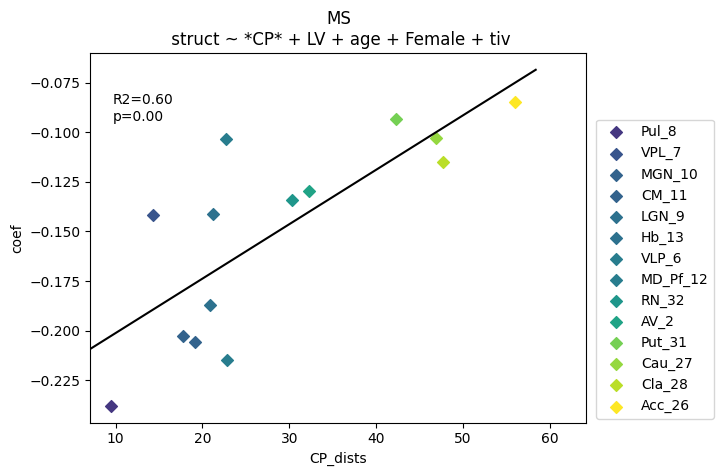

#### Keep all points

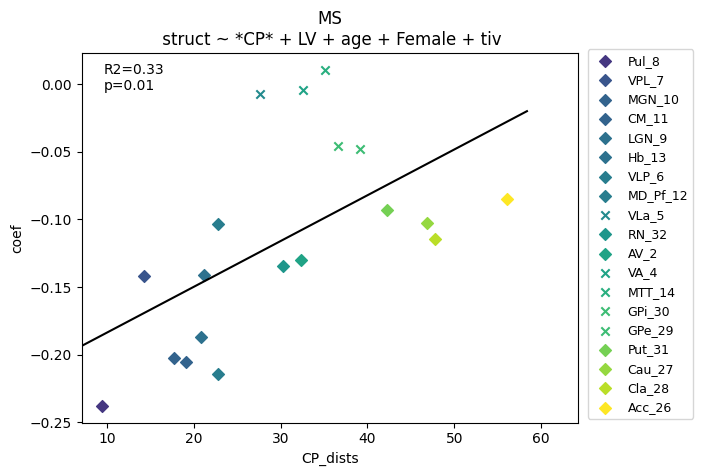

In [27]:
save = False
show = True
save_stem = "CP_betas_vs_CP_dists"

model_data = data_ms_z

covariates = ["LV", "age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]

predictor = ["CP", "LV_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data["allCSF_dists"] = mni_allCSF_dists
data["outerCSF_dists"] = mni_outerCSF_dists
data["ventricle_SDT_dist"] = mean_ventricle_sdt_dists
data["ventricle_centroid_dist"] = mean_ventricle_sdt_dists


display(Markdown("#### Remove points that weren't significant"))
fig, axes = plt.subplots()
axs = axes
_, _, plot_data = plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=True,
    legend_fontsize=10
)
plt.show()
sig_structs = plot_data.index

fig, axes = plt.subplots()
axs = axes
plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=False,
    legend_fontsize=9
)
display(Markdown("#### Keep all points"))


if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


In [198]:
check = data_orig.sort_values(by="LV", ascending=False)
check

,subject,sz_onset,dzdur,MSSS,gMSSS,ARMSS,sex,age,obs_start_date,obs_end_date,...,MD_Pf_12_LV_sdt,Hb_13_LV_sdt,MTT_14_LV_sdt,Acc_26_LV_sdt,Cau_27_LV_sdt,Cla_28_LV_sdt,GPe_29_LV_sdt,GPi_30_LV_sdt,Put_31_LV_sdt,RN_32_LV_sdt
subid,,,,,,,,,,,,,,,,,,,,,
1079,ms1079,1/1/1991,29.737721,2.23,2.75,3.10,Male,64.447243,9/27/2020,9/27/2020,...,7.176633,8.569207,9.006665,5.228435,3.294436,19.406788,10.939510,11.296551,15.117999,17.830874
2027,ms2027,1/1/1993,25.239555,4.88,5.54,5.15,Female,63.776488,3/30/2018,3/30/2018,...,5.250631,7.957359,8.389691,4.730870,3.199992,18.256591,9.894743,10.039089,13.805195,14.834762
1077,ms1077,1/1/1998,20.385479,3.93,4.96,4.74,Male,59.784811,5/22/2018,5/22/2018,...,9.390156,9.854592,10.033517,5.511735,4.837393,19.669115,10.083750,11.035936,14.557616,18.102210
1299,ms1299,1/1/2016,4.292833,6.98,7.45,3.62,Male,58.448776,4/17/2020,4/17/2020,...,8.641948,9.501530,10.887536,5.711026,5.952775,22.478700,12.872896,12.768664,16.979005,18.727413
2243,ms2243,.,NaN,NaN,NaN,NaN,Male,58.607567,1/15/2022,1/15/2022,...,8.176520,9.346516,11.184159,6.816387,5.244548,21.284960,12.360431,12.469854,16.846842,18.724867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,ms1357,1/1/2020,1.133439,9.09,8.64,8.86,Female,20.870065,2/18/2021,2/18/2021,...,9.682847,14.411061,12.821478,6.974082,5.931964,23.561284,12.262383,13.177082,17.301820,20.976165
1364,ms1364,6/1/2010,7.093577,NaN,NaN,NaN,Female,30.200405,7/5/2017,7/5/2017,...,10.937919,13.646257,13.047606,6.512050,6.244856,23.677537,12.622195,13.604064,17.903265,22.420182
2006,ms2006,6/1/2013,3.800033,2.87,3.65,1.41,Female,51.886328,3/20/2017,3/20/2017,...,9.118094,12.470762,11.398246,5.810859,6.136932,23.487766,12.294235,12.642605,17.451730,20.705405


In [13]:
# maybe I should return t stats instead of the final p_boot
print(covariates)
print(hips_thomas_ref[sig_structs])
slopes, intercepts, r_values, p_boot = bootstrap_procedure(
    model_data, choroid_dists, covariates, var_to_plot, hips_thomas_ref[sig_structs]
)

['periCSF_frac', 'age', 'Female', 'tiv']
index
8        Pul_8
7        VPL_7
10      MGN_10
11       CM_11
9        LGN_9
13       Hb_13
6        VLP_6
12    MD_Pf_12
32       RN_32
2         AV_2
31      Put_31
27      Cau_27
28      Cla_28
26      Acc_26
Name: struct, dtype: object


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(9.664058283977107, -0.05, 'Bootstrapped:\nR2=0.46\np=0.00')

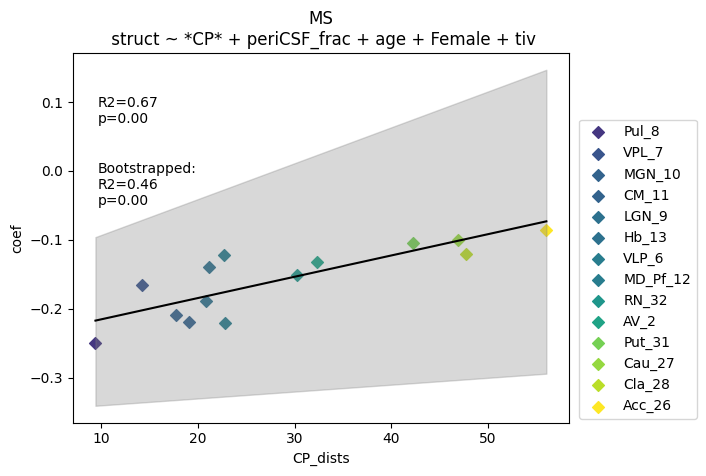

In [15]:
x_range = np.linspace(data['CP_dists'].min(), data['CP_dists'].max())
sort_slopes = sorted(slopes)
sort_intercepts = sorted(intercepts)
y_low = sort_intercepts[25] + sort_slopes[25]*x_range
y_high = sort_intercepts[975] + sort_slopes[975]*x_range
y = intercepts.mean() + slopes.mean()*x_range

r2 = r_values.mean()**2
p = p_boot

fig, axs = plt.subplots()

plot_xordered_data(
    plot_data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=False,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    text_y = 0.07
)

axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
axs.plot(x_range, y, color='black')
xlims = axs.get_xlim()
ylims = axs.get_ylim()
text = "Bootstrapped:\nR2={:0.2f}\np={:0.2f}".format(r2, p)
# text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.85
text_y = -0.05
text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
axs.text(text_x, text_y, text, fontsize=10)


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)


#### Remove points that weren't significant

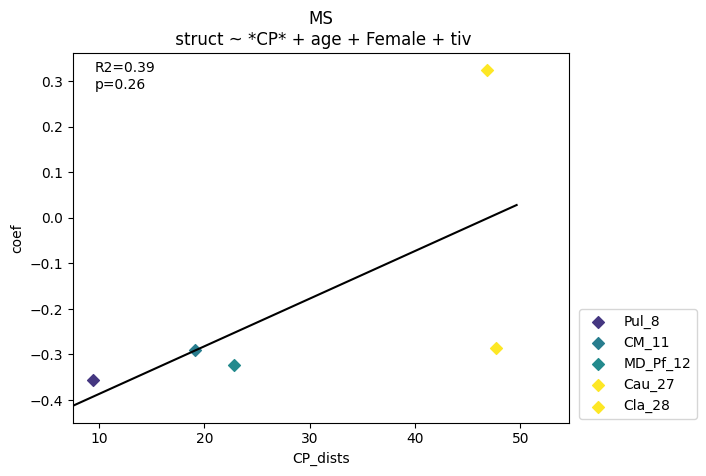

#### Keep all points

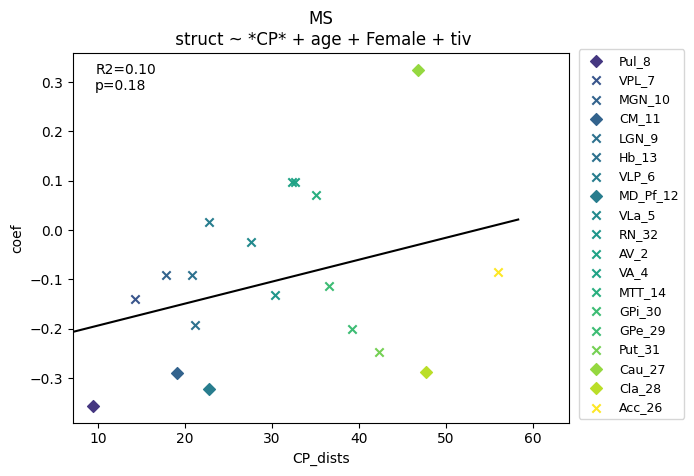

In [19]:
save = False
show = True
save_stem = "CP_betas_vs_CP_dists"

model_data = zscore(data_orig[NIND_patients])

covariates = ["age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]

predictor = ["CP", "LV_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data["allCSF_dists"] = mni_allCSF_dists
data["outerCSF_dists"] = mni_outerCSF_dists
data["ventricle_SDT_dist"] = mean_ventricle_sdt_dists
data["ventricle_centroid_dist"] = mean_ventricle_sdt_dists


display(Markdown("#### Remove points that weren't significant"))
fig, axes = plt.subplots()
axs = axes
_, _, plot_data = plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=True,
    legend_fontsize=10
)
plt.show()
sig_structs = plot_data.index

fig, axes = plt.subplots()
axs = axes
plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=False,
    legend_fontsize=9
)
display(Markdown("#### Keep all points"))


if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)


#### Remove points that weren't significant

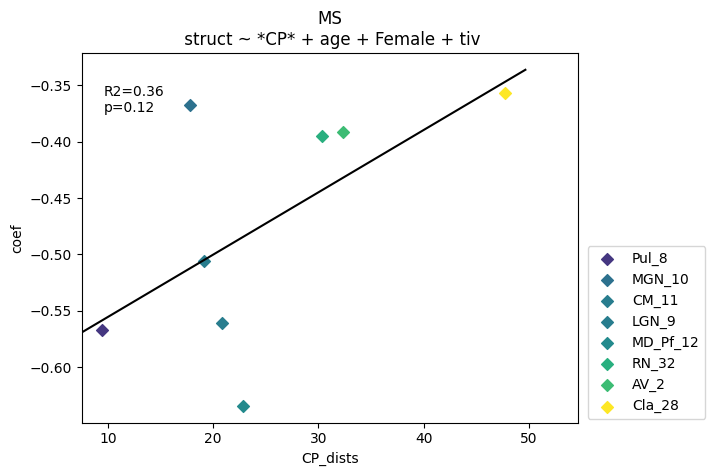

#### Keep all points

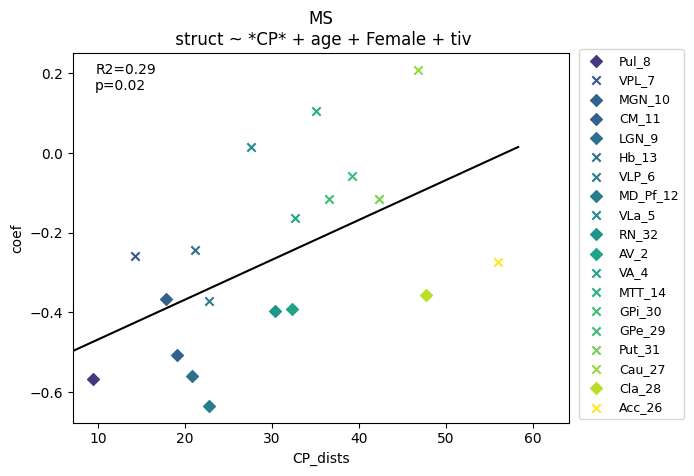

In [20]:
save = False
show = True
save_stem = "CP_betas_vs_CP_dists"

model_data = zscore(data_orig[OIND_patients])

covariates = ["age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]

predictor = ["CP", "LV_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data["allCSF_dists"] = mni_allCSF_dists
data["outerCSF_dists"] = mni_outerCSF_dists
data["ventricle_SDT_dist"] = mean_ventricle_sdt_dists
data["ventricle_centroid_dist"] = mean_ventricle_sdt_dists


display(Markdown("#### Remove points that weren't significant"))
fig, axes = plt.subplots()
axs = axes
_, _, plot_data = plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=True,
    legend_fontsize=10
)
plt.show()
sig_structs = plot_data.index

fig, axes = plt.subplots()
axs = axes
plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=False,
    legend_fontsize=9
)
display(Markdown("#### Keep all points"))


if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)
